In [7]:
import os
import math
import numpy as np
from matplotlib import pyplot as plt
import time
import torch

testDir = "/home/mrim/quenot/irim/pytorch/dual_encoding_experiments/VisualSearchResults/msrvtt10k/test_results"

In [8]:
def pltscale(scale):
    if scale == 'log':
        plt.xscale('log', base=2)
    else:
        plt.xscale('linear')

def tpca(a, q=65536):
    t0 = time.time()
    a = torch.tensor(a)
    m = a.mean(axis = 0)
    u, s, v = torch.pca_lowrank(a, q=min(a.size(1), q), center=True)
    print(time.time()-t0)
    return m.numpy(), u.numpy(), s.numpy(), v.numpy()

def loadEmbs(testDir, expName, runNum, embsName="embs.pth"):
    runDir = os.path.join(testDir, expName, "runs_%d/model_best" % runNum)
    embs = torch.load(os.path.join(runDir, embsName))
    return embs

(62790, 11)
0.046019792556762695
(62790, 16)
0.04464077949523926
(62790, 22)
0.07999610900878906
(62790, 32)
0.14094233512878418
(62790, 45)
0.15878081321716309
(62790, 64)
0.27666807174682617
(62790, 90)
0.24655675888061523
(62790, 128)
0.4910759925842285
(62790, 181)
0.6037015914916992
(62790, 256)
0.9525294303894043
(62790, 362)
1.6406519412994385
(62790, 512)
5.7848801612854
(62790, 724)
5.815461874008179
(62790, 1024)
10.661539793014526
(62790, 1448)
14.103532791137695
(62790, 2048)
25.791372776031494
(62790, 2896)
47.31366443634033
(62790, 4096)
94.81596350669861


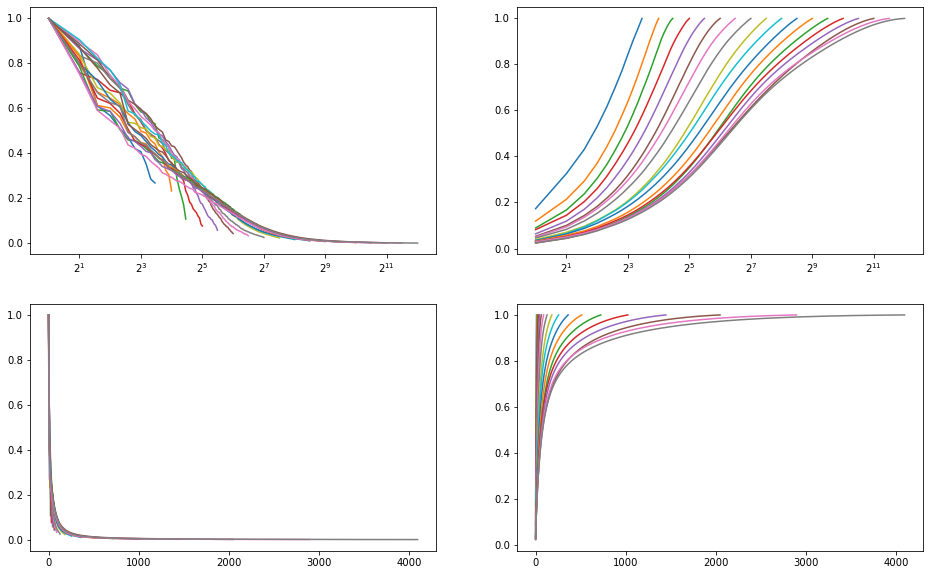

In [24]:
dims = (2**np.linspace(3, 12, num=19)).astype(int)

fig, axes = plt.subplots(2, 2, figsize=(16, 10))
for j in range(2):
    axes[0][j].set_xscale("log", base=2)
for n, dim in enumerate(dims[1:]):
    embs = loadEmbs(testDir, "latent", dim)
    capvid = embs['cap_embs']
    for i in range(1):
        capvid = np.concatenate((capvid, embs['video_embs']))
    print(capvid.shape)
    s = tpca(capvid)[2]
    axes[0][0].plot(range(1,dim+1),np.square(s)/np.square(s).max())
    axes[0][1].plot(range(1,dim+1),np.cumsum(np.square(s))/np.sum(np.square(s)))
    axes[1][0].plot(range(1,dim+1),np.square(s)/np.square(s).max())
    axes[1][1].plot(range(1,dim+1),np.cumsum(np.square(s))/np.sum(np.square(s)))

In [2]:
t0 = time.time()
vid, cap = [], []
nr = 20
for n in range(nr):
    runDir = os.path.join(testDir,"latent_2048_pca/runs_%d/model_best" % n)
    embs = torch.load(os.path.join(runDir,"embs.pth"))
    vid.append(torch.tensor(embs['video_embs']))
    cap.append(torch.tensor(embs['cap_embs']))
vid = torch.cat(vid,dim=1)/math.sqrt(nr)
cap = torch.cat(cap,dim=1)/math.sqrt(nr)
vc = [cap]
for i in range(1):
    vc.append(vid)
# vid = vid/vid.square().sum(axis=1).sqrt().unsqueeze(1)
# cap = cap/cap.square().sum(axis=1).sqrt().unsqueeze(1)
vc = torch.cat(vc, dim=0)
print(time.time()-t0)

234.90058088302612


In [3]:
t0 = time.time()
q = min(vc.size(1), 4096)
m = vc.mean(axis = 0)
u, s, v = torch.pca_lowrank(vc, q=q, center=True)
print(time.time()-t0)

450.56459379196167


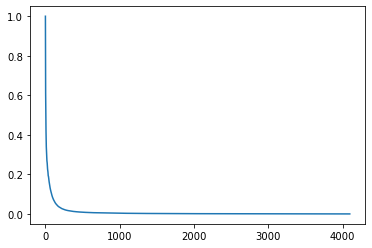

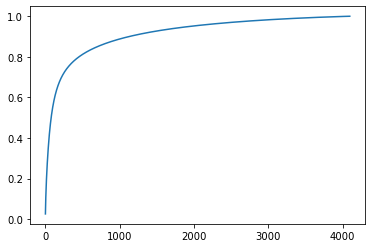

In [4]:
scale = 'linear'
q = 4096
pltscale(scale)
plt.plot(range(1,q+1),(s.square().numpy()/s.square().max()))
plt.show()
pltscale(scale)
plt.plot(range(1,q+1),(np.cumsum(s.square().numpy())/np.sum(s.square().numpy()))[:q])
plt.show()

40960 4096
0.9596584035417218


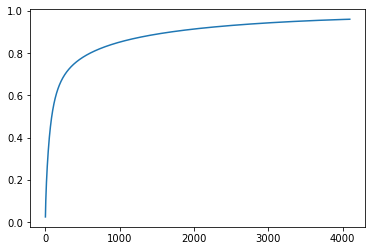

In [7]:
q = 4096
print(vc.size(1), q)
rvid = (torch.matmul(vid, v))[:,:q]
rcap = (torch.matmul(cap, v))[:,:q]
# rvid = rvid/rvid.square().sum(axis=1).sqrt().unsqueeze(1)
# rcap = rcap/rcap.square().sum(axis=1).sqrt().unsqueeze(1)
rvc = (torch.matmul(vc-m, v))[:,:q]
pltscale(scale)
ev = (torch.cumsum(rvc.square().sum(dim=0),dim=0)/(vc-m).square().sum())[:q]
print(ev[-1].item())
plt.plot(range(1,q+1),ev.numpy())
plt.show()

In [8]:
save_embs = "embs_fuse_%d_%d.pth" % (nr, q)
print(save_embs)
runDir = os.path.join(testDir,"latent_2048_pca/runs_0/model_best")
torch.save({'video_embs': rvid.numpy(), 'video_tag_scores': None,
            'cap_embs': rcap.numpy(), 'cap_tag_scores': None,}, os.path.join(runDir, save_embs))

embs_fuse_20_4096.pth
